In [9]:
!pip install flask

In [1]:
import requests
import pandas as pd

# Load the Google API key from a text file
with open('g_api_key_2.txt') as file:
    api_key = file.read().strip()

# Initialize variables
video_id = "T3FC7qIAGZk"
url = f"https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&videoId={video_id}&key={api_key}&maxResults=100"
comments = []
page_token = None

In [2]:
# Initialize the comments list and page token
comments = []
page_token = None

# Fetch 1000 comments (10 API requests with maxResults=100)
for _ in range(10):
    if page_token:
        url_with_token = f"{url}&pageToken={page_token}"
        response = requests.get(url_with_token)
    else:
        response = requests.get(url)

    data = response.json()
    page_token = data.get("nextPageToken", None)

    for item in data["items"]:
        comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
        comments.append(comment)

    # Break if there are no more comments to fetch
    if not page_token:
        break

# Converting the list of comments to a DataFrame
df_comments = pd.DataFrame(comments, columns=["Comment"])

In [3]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming df_comments already has a 'Comment' column
df_comments['Sentiment'] = df_comments['Comment'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [9]:
# Import Plotly
import plotly.graph_objects as go

# Set color scheme to Plasma
color_scheme = 'Plasma'

# Create the histogram with customized features
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_comments['Sentiment'],
    xbins=dict(
        start=-1.0,
        end=1.0,
        size=0.1
    ),
    marker=dict(
        color=df_comments['Sentiment'],
        colorscale=color_scheme,
        line=dict(
            color='rgba(255, 255, 255, 1)',
            width=2
        )
    ),
    opacity=0.75
))

# Custom tick labels with larger emojis
custom_ticktext = ['😥', '😟', '😐', '😊', '😃']
custom_tickvals = [-1, -0.5, 0, 0.5, 1]

# Update layout with customized features
fig.update_layout(
    title_text='Feel the Vibe: YouTube Comment Sentiments 📝',
    xaxis_title_text='Vibe Check',
    yaxis_title_text='How Many Feel This Way?',
    bargap=0.1,
    bargroupgap=0.1,
    xaxis=dict(
        tickvals=custom_tickvals,
        ticktext=custom_ticktext,
        tickfont=dict(size=48),  # 4x larger emojis
        titlefont=dict(size=24)  # 2x larger text for "Vibe Check"
    ),
    yaxis=dict(
        titlefont=dict(size=24)  # 2x larger text
    ),
    title=dict(
        font=dict(size=24)  # 2x larger title text
    ),
    template='plotly_dark',
    annotations=[
        dict(
            x=0,
            y=0,
            xref='x',
            yref='y',
            text='Neutral Zone 😐',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40,
            font=dict(
                size=24  # 2x larger text for "Neutral Zone"
            )
        )
    ]
)

fig.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


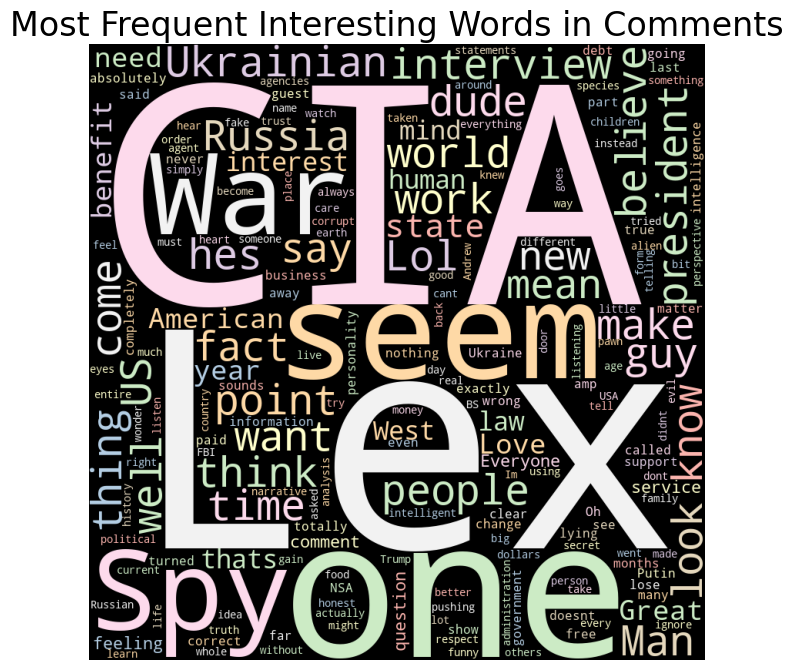

In [5]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Combine all comments into a single string
all_comments = ' '.join(df_comments['Comment'])

# Remove unwanted characters and numbers using regex
cleaned_comments = re.sub(r'[^\w\s\']', '', all_comments)  # Keep apostrophes
cleaned_comments = re.sub(r'\b\d+\b', '', cleaned_comments)  # Remove standalone numbers

# Replace '39' with an actual apostrophe
cleaned_comments = cleaned_comments.replace('39', "'")

# Tokenize and remove stopwords
tokens = cleaned_comments.split()
filtered_tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]

# Count word frequencies and filter
word_freq = Counter(filtered_tokens)
filtered_words = [word for word, freq in word_freq.items() if freq > 5]  # Change the frequency threshold as needed

# Create a string from the filtered words
filtered_comments = ' '.join(filtered_words)

# Generate the word cloud
wordcloud = WordCloud(background_color='black',
                      width=800,
                      height=800,
                      min_font_size=10,
                      colormap='Pastel1').generate(filtered_comments)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most Frequent Interesting Words in Comments', fontsize=24)  # Increased font size
plt.show()

In [6]:
import plotly.express as px

# Calculate the length of each comment
df_comments['Comment_Length'] = df_comments['Comment'].apply(len)

# Create the histogram
fig = px.histogram(df_comments, x='Comment_Length',
                   title='Distribution of Comment Lengths',
                   labels={'Comment_Length': 'Length of Comment'},
                   template='plotly_dark',
                   color_discrete_sequence=['#00CC96'])

# Add axis labels and title
fig.update_layout(
    xaxis_title='Comment Length',
    yaxis_title='Frequency'
)

fig.show()

In [7]:
import plotly.graph_objects as go
import numpy as np

# Calculate the length of each comment
df_comments['Comment_Length'] = df_comments['Comment'].apply(len)

# Calculate and round the average comment length
avg_length = round(np.mean(df_comments['Comment_Length']))

# Create the histogram
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_comments['Comment_Length'],
    marker=dict(
        color='rgba(255, 113, 206, 0.7)',  # Neon Pink for bars
        line=dict(
            color='rgba(0, 255, 255, 1)',  # Neon Blue for bar outlines
            width=2
        )
    ),
    opacity=0.75
))

# Add titles and labels
fig.update_layout(
    title='How Long Are Most Comments?',
    xaxis=dict(
        title='Number of Characters in Comment',
        range=[0, max(df_comments['Comment_Length'])],
        linecolor='rgba(0, 255, 0, 1)',  # Neon Green for x-axis line
        linewidth=2
    ),
    yaxis=dict(
        title='Number of Comments',
        range=[0, 250],  # Set y-axis range to top out at 250
        linecolor='rgba(255, 255, 0, 1)',  # Neon Yellow for y-axis line
        linewidth=2
    ),
    template='plotly_dark',
    annotations=[
        dict(
            x=avg_length,
            y=0,
            xref='x',
            yref='y',
            text=f"Avg Length: {avg_length} Characters",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=1,
            y=1,
            xref='paper',
            yref='paper',
            text="This chart shows how many characters are in most comments. The arrow points to the average length.",
            showarrow=False,
            font=dict(
                size=12,
                color='white'
            ),
            bgcolor='black',
            bordercolor='white',
            borderwidth=1,
            opacity=0.8
        )
    ]
)

fig.show()

In [8]:
import plotly.express as px

# Create the scatter plot
fig = px.scatter(df_comments, x='Comment_Length', y='Sentiment',
                 title='What\'s the Vibe in Longer Comments?',
                 labels={'Comment_Length': 'How Long is the Comment?', 'Sentiment': 'Feeling'},
                 template='plotly_dark',
                 color='Sentiment',
                 color_continuous_scale='Viridis')

# Add axis labels and title
fig.update_layout(
    title=dict(
        text='What\'s the Vibe in Comments Section?',
        font=dict(
            size=24
        )
    ),
    xaxis_title='Comment Size',
    yaxis_title='Good or Bad Vibes?',
    xaxis=dict(
        title_font=dict(
            size=18
        )
    ),
    yaxis=dict(
        title_font=dict(
            size=18
        )
    ),
    annotations=[
        dict(
            x=0,
            y=1,
            xref='x',
            yref='y',
            text="😄",
            showarrow=False,
            font=dict(
                size=36
            )
        ),
        dict(
            x=0,
            y=0,
            xref='x',
            yref='y',
            text="😐",
            showarrow=False,
            font=dict(
                size=36
            )
        ),
        dict(
            x=0,
            y=-1,
            xref='x',
            yref='y',
            text="😞",
            showarrow=False,
            font=dict(
                size=36
            )
        )
    ]
)

fig.show()

In [10]:
!python --version

Python 3.9.13
